---
title: Customer-Based Corporate Valuation for Subscription-Based Businesses
author: Abdullah Mahmood
date: last-modified
format:
    html:
        theme: cosmo
        css: quarto-style/style.css
        highlight-style: atom-one
        mainfont: Palatino
        fontcolor: black
        monobackgroundcolor: white
        monofont: Menlo, Lucida Console, Liberation Mono, DejaVu Sans Mono, Bitstream Vera Sans Mono, Courier New, monospace
        fontsize: 13pt
        linestretch: 1.4
        number-sections: true
        number-depth: 5
        toc: true
        toc-location: right
        toc-depth: 5
        code-fold: true
        code-copy: true
        cap-location: bottom
        format-links: false
        embed-resources: true
        anchor-sections: true
        code-links:
        -   text: GitHub Repo
            icon: github
            href: https://github.com/abdullahau/customer-analytics/
        -   text: Quarto Markdown
            icon: file-code
            href: https://github.com/abdullahau/customer-analytics/blob/main/buyer-behavior-summary-transaction-log.qmd
        html-math-method:
            method: mathjax
            url: https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js
---

### Source

This model presented in this notebook is a direct implementation of *Daniel M. McCarthy, Peter S. Fader and Bruce G. S. Hardie*'s 2016 paper [*Valuing Subscription-Based Businesses Using Publicly Disclosed Customer Data*](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2701093).

I will also implement the models proposed by *Sunil Gupta, Donald R. Lehmann, and Jennifer Ames Stuart* in their 2004 paper [*Valuing Customers*](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=459595), and *Christian Schulze, Bernd Skiera, and Thorsten Wiesel* in their 2012 paper [*Linking Customer and Financial Metrics to Shareholder Value: The Leverage Effect in Customer-Based Valuation*](https://journals.sagepub.com/doi/abs/10.1509/jm.10.0280) as benchmarks.

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg']

## Introduction

The subscription-based business model—where customers pay recurring fees for ongoing access to a product or service—has seen significant growth beyond its traditional domains of media and telecom. Today, it underpins a wide range of consumer and B2B offerings, including SaaS (e.g., Microsoft 365), meal kits (e.g., Blue Apron), and consumer goods (e.g., Dollar Shave Club). A key driver of this model’s appeal is the predictability of revenue streams.

As subscription businesses scale, they increasingly disclose customer-related metrics such as **churn**, **acquisition cost** (CAC), **average revenue per user** (ARPU), and **customer lifetime value** (CLV). These metrics are critical for understanding a firm’s future cash flows—especially since, in subscription settings, customer behavior largely drives economic value. Equity analysts and investors now routinely incorporate this data into valuation models, with subscriber base growth often serving as a key signal.

In this notebook, I implement the framework (and its models) from [McCarthy, Fader, and Bruce (2016)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2701093), which estimates firm value using only publicly disclosed customer data. Central to this framework are models of the firm's **acquisition** and **retention processes**, which accommodate factors such as *customer heterogeneity*, *duration dependence*, *seasonality*, and *changes in population size*.

We explicitly account for the fact that publicly reported data are typically *aggregated* (temporally and across customers) and suffer from *missingness* (i.e., the reported data are not available for all periods). 

I begin by reviewing the principles of customer-based corporate valuation and the nature of the data available from subscription firms. I then introduce models for acquisition, retention, and spending behavior, and estimate their parameters using historical data from two publicly traded firms: Dish Network (DISH) and Sirius XM (SIRI).

Once validated, the model is used to generate forward-looking estimates of customer behavior, firm-level revenue, and ultimately, equity value. I also highlight additional strategic insights that emerge from the estimated parameters and model outputs.

## The Logic of Customer-Based Corporate Valuation

### Valuation 101

The framework summarized here is a discounted cash flow (DCF) model, which is the de-facto industry standard way in which operating assets are valued within the financial community. At the heart of any such valuation exercise is the estimation of period-by-period FCF, central to which are estimates of period-by-period revenue.

Denoting the value of the firm at time $T$ by $\text{SHV}_T$ (for shareholder value), we have

$$
\text{SHV}_T = \text{OA} + \text{NOA}_T - \text{ND}_T
$$

The value of a firm’s operating assets ($\text{OA}$) is equal to the sum of all *expected* future free cash flows (FCFs) the firm will generate, discounted at the weighted average cost of capital ($\text{WACC}$):

$$
\text{OA}_T = \sum_{t=0}^{\infty} \frac{\text{FCF}_{T+t}}{(1+\text{WACC})^{t}}
$$


FCF is equal to the net operating profit after taxes ($\text{NOPAT}$) minus the difference between capital expenditures ($\text{CAPEX}$) and depreciation and amortization ($\text{D\&A}$), minus the change in non-financial working capital ($\Delta\text{NFWC}$):

$$
\text{FCF}_t = \text{NOPAT}_t - (\text{CAPEX}_t - \text{D\&A}_t) - \Delta\text{NFWC}_t
$$

The most important ingredient of FCF is $\text{NOPAT}$, which is a measure of the underlying profitability of the operating assets of the firm. $\text{NOPAT}$ is equal to revenues ($\text{REV}$) times the contribution margin ratio ($1 - \text{VC}$) minus fixed operating costs ($\text{FC}$), after taxes (where $\text{TR}$ is the corporate tax rate for the firm):

$$
\text{NOPAT}_t = \left(\text{REV}_t \times (1 - \text{VC}) - \text{FC}_t \right) \times \left(1- \text{TR}_t\right)
$$

### A Data Structure for Subscription-Based Businesses

![](references/num_customer_matrix.png){fig-align="center" width="350"}

Let us assume that the firm has a monthly internal reporting period. The key numbers of interest are monthly revenues, which we denote by R(m) (where m = 1 corresponds to the firm’s first month of commercial operations).

While it might be temping to approach the task of forecasting revenue by using a time-series model, a few moments of reflection will suggest that it makes more sense to first decompose these aggregate revenue numbers, separately model the constituent components, and then combine the forecasts of these components to arrive at the desired revenue forecasts. First, we should recognize that revenue comes from customers, so decomposing revenue into its “number of customers” and “average revenue per customer” components would be a good start. Second, as we think about the number of customers the firm has in a month, it makes sense to decompose this quantity into the number of new customers acquired that month and the number of customers acquired in previous months who still have a relationship with the firm. Knowing the number of new customers acquired of each month is a critical input to any valuation exercise, especially for firms with high subscriber acquisition costs. It is important to note that such information will be overlooked if we simply apply a time-series model to the revenue numbers.

This is similar to the models I have implemented in the following notebooks: [Depth-of-Repeat Model - Forecasting Aggregate Repeat-Buying](https://abdullahau.github.io/customer-analytics/DoR-Model), [Sales Forecast: Predicting Unit Sales Using Finite Mixture Model with Beta-Geometric Distribution](https://abdullahau.github.io/customer-analytics/Sales-Forecast-Finite-Mixture-Beta-Geometric) and [NEW]. The basic idea is that we i) first decompose total sales into its trial and repeat components, ii) develop separate models for trial and repeat sales, and ii) then combine the associated forecasts of these components to arrive at a forecast of total sales.

There is an obvious parallel with the new product sales forecasting literature (e.g., Fourt and Woodlock 1960; Eskin 1973; Fader, Hardie, and Huang 2004), where 

First, we should recognize that revenue comes from customers, so decomposing

- $R(m)$ -> Monthly revenue
- $m = 1$ -> first month of commercial operations
- $C(m, m’)$ -> number of customers acquired by the firm in month $m$ who are still active in month $m’$
- $A(m) = C(m, m’)$ -> number of customers acquired each month by the firm
- $L(m)$ -> number of customers “lost” each month
- $L(m)$ = 0 if m = 0, else $C(., m-1) - [C(., m) - C(m,m)]$
	- eg. $L(3) = C(., 2) - [C(., 3) - C(3,3)]$
$$
L(m) = 
	\begin{cases}
		0 &\quad m =1 \\
		C(., m-1) - [C(., m) - C(m,m)]&\quad m = 2,3,4, \ldots
	\end{cases}
$$
- *Aggregate* churn rate = $L(m)/C(.,m-1)$
- $ARPU(m)$ -> Average revenue per subscriber in a given month
- $ARPU(m) = R(m) \big/ \frac{C(.,m-1) + C(.,m)}{2}$
	- (The denominator is the average number of customers the firm has during month $m$.)
- $q$ quarter is a temporal aggregation of the true underlying process.
- $q = 1$ is equivalent to $m=\{1,2,3\}$.
- $\text{END}_q = C(., 3q)$
- $\text{ADD}_q = A(3q-2) + A(3q-1) + A(3q)$
- $\text{LOSS}_q = L(3q-2) + L(3q-1) + L(3q)$
- $REV_q = R(3q-2) + R(3q-1) + R(3q)$
- Objective: generate long-run projections of $R(m)$ and $A(M)$ using parameters estimated from $\text{ADD}$, $\text{LOSS}$, $\text{END}$ and $\text{REV}$ numbers
- Account for **missing data**:
	- **Left-censoring** - Disclosure records of paying customers does not start from the beginning of commercial operations.
	- Some measures are reported for some period of time (e.g., $\text{END}$) before being complemented by other measures (e.g., $\text{ADD}$ and $\text{LOSS}$).
- Account for **aggregation** (quarterly reports to monthly figures)
	- Publicly disclosed customer data is typically reported quarterly with the associated unit of time being the quarter, whereas the firm is operating on a finer time interval (which, for the purposes of our analysis, we assume to be the month).

-  [US Census Bureau’s Housing Vacancies and Homeownership CPS/HVS](https://www.census.gov/housing/hvs/data/histtabs.html) 
-  [Quarterly Estimates of the Housing Inventory](https://www.census.gov/housing/hvs/data/histtab8.xlsx):

Alternative Source: FRED (EOCCUSQ176N) Housing Inventory Estimate: Occupied Housing Units in the United States

-   **Units**: Thousands of Units, Not Seasonally Adjusted
-   **Frequency**: Quarterly
-   **Notes**: A housing unit is occupied if a person or group of persons is living in it at the time of the interview or if the occupants are only temporarily absent, as for example, on vacation. The persons living in the unit must consider it their usual place of residence or have no usual place of residence elsewhere. The count of occupied housing units is the same as the count of households.

In [2]:
file_path = "data/quarterly-estimates-housing-inventory-US.csv"
household_full = pd.read_csv(file_path)
household_full

,Year,Q1,Q2,Q3,Q4
0,1965,56848,57459,57846,57850
1,1966,57676,58646,58925,58696
2,1967,58493,59143,60133,60133
3,1968,60451,60739,61196,61423
4,1969,61759,62141,62412,62730
...,...,...,...,...,...
59,2020,124391,126780,126703,125805
60,2021,125944,126155,126914,127430
61,2022,127574,127990,128307,129396
62,2023,129234,130100,130386,131206


In [3]:
file_path = "data/revised-quarterly-estimates-housing-inventory-US.csv"
household_revised = pd.read_csv(file_path)
household_revised

,Year,Q1,Q2,Q3,Q4
0,2000,NaN,102274,102896,103646
1,2001,103456.0,103411,104228,104698
2,2002,104719.0,105276,105527,105759
3,2003,105884.0,105989,106068,106505
4,2004,106738.0,107020,107932,108735
5,2005,108863.0,109057,109736,110281
6,2006,110350.0,110560,110779,111096
7,2007,110715.0,111342,111251,111724
8,2008,111326.0,111601,111939,111823
9,2009,111862.0,112453,112381,112485


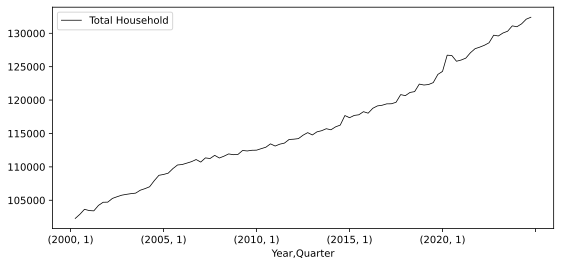

In [4]:
household_full_lf = (
    pd.wide_to_long(household_full, stubnames="Q", i="Year", j="Quarter")
    .sort_index()
    .rename(columns={"Q": "Total Household"})
)
household_rev_lf = (
    pd.wide_to_long(household_revised, stubnames="Q", i="Year", j="Quarter")
    .sort_index()
    .rename(columns={"Q": "Total Household"})
)
household_rev_lf.plot(figsize=(9, 4), linewidth=0.75, color="k");

In [5]:
dish_op_res = pd.read_csv(
    'data/DISH - ADD-LOSS-END.csv', 
    index_col='Date', 
    parse_dates=True,
    dayfirst=True
).sort_index()
dish_op_res.tail()

,Year,Quarter,Service revenue,Total Revenue,Subscriber Acquisition Costs (SAC),Equipment Capitalized,Pay-TV Subscribers,"Pay-TV Subscriber additions, gross","Implied Subscriber additions, gross","Pay-TV Subscriber additions, net","Implied Pay-TV Subscriber additions, net",Pay-TV Churn Rate (average monthly),Pay-TV SAC per Subscriber (average),Pay-TV ARPU (average monthly),Combined Additions,Combined Net Additions
Date,,,,,,,,,,,,,,,,
2014-03-31,2014,1,3556187.0,3594198.0,NaN,NaN,14.097,0.639,NaN,0.040,0.040,0.0142,862.0,82.36,0.639,0.040
2014-06-30,2014,2,3645101.0,3688119.0,NaN,NaN,14.053,0.656,NaN,-0.044,-0.044,0.0166,846.0,84.15,0.656,-0.044
2014-09-30,2014,3,3647850.0,3679351.0,NaN,NaN,14.041,0.691,NaN,-0.012,-0.012,0.0167,861.0,84.39,0.691,-0.012
2014-12-31,2014,4,3645953.0,3681719.0,NaN,NaN,13.978,0.615,NaN,-0.063,-0.063,0.0159,853.0,83.77,0.615,-0.063
2015-03-31,2015,1,3693530.0,3724228.0,NaN,NaN,13.844,0.723,NaN,-0.134,-0.134,0.0164,667.0,85.73,0.554,-0.134


- [U.S. Recession Bars](https://fredhelp.stlouisfed.org/fred/data/understanding-the-data/recession-bars/)
- [Business Cycle Dating](https://www.nber.org/research/business-cycle-dating)

In [6]:
# Gross Customer Acquisition Every Quarter
dish_ADD = dish_op_res['Combined Additions'] * 1000
# Surviving Customers at the End of Quarter
dish_END = dish_op_res['Pay-TV Subscribers'] * 1000
# Customer Churn Every Quarter
dish_LOSS = (
    dish_op_res["Pay-TV Subscribers"].shift(periods=1)
    + dish_op_res["Combined Additions"]
    - dish_op_res["Pay-TV Subscribers"]
) * 1000

In [7]:
def dish_plot_format(ax, data):
    # Recession bar
    ax.axvspan(pd.to_datetime("12/1/2007"), pd.to_datetime("06/1/2009"), color='gray', alpha=0.3)
    # Padding
    pad = pd.DateOffset(months=12)
    ax.set_xlim(data.index.min() - pad, data.index.max() + pad)
    # x-ticks
    ax.set_xticks(data.index[::8])
    ax.set_xticklabels([f"Q{((d.month-1)//3)+1} {d.year}" for d in data.index[::8]], rotation=45)
    plt.tight_layout()
    plt.show()
    return

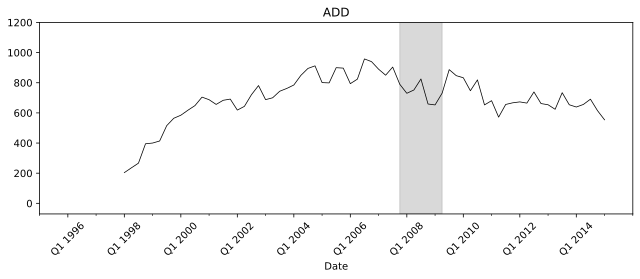

In [8]:
# Gross Customer Acquisition Every Quarter
_, ax = plt.subplots(figsize=(9, 4))
dish_ADD.plot(ax=ax, color='k', linewidth=0.75, title='ADD', ylim=(-70, 1200))
dish_plot_format(ax, dish_ADD)

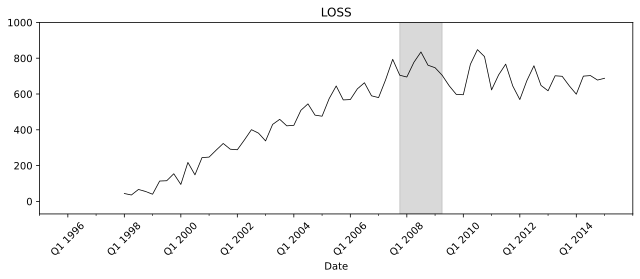

In [9]:
# Customer Churn Every Quarter
_, ax = plt.subplots(figsize=(9, 4))
dish_LOSS.plot(ax=ax, color="k", linewidth=0.75, title="LOSS", ylim=(-70, 1000))
dish_plot_format(ax, dish_LOSS)

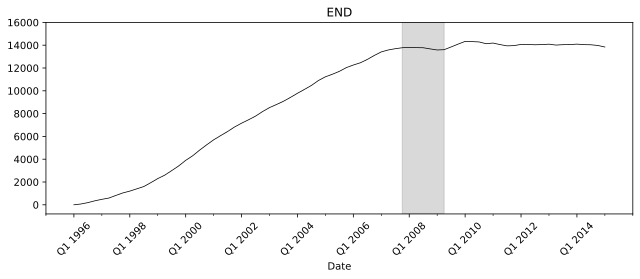

In [10]:
# Surviving Customers at the End of Quarter
_, ax = plt.subplots(figsize=(9, 4))
dish_END.plot(ax=ax, color='k', linewidth=0.75, title='END', ylim=(-800,16000))
dish_plot_format(ax, dish_END)

Number of vehicles on the road data: 

-  [Highway Statistics - State motor-vehicle registrations - MV-1](https://www.fhwa.dot.gov/policyinformation/statistics.cfm)
-  [Automobile Profile - Bureau of Transportation Statistics](https://www.bts.gov/content/automobile-profile)

Data description:
-   **Units**: Number of Units
-   **Frequency**: Annually
-   **Notes**: Total number of registered private, commercial (incl. taxicabs), and public automobiles in the US every year (excluding buses, trucks, and motorcycles)

In [11]:
reg_cars = pd.read_csv('data/us_registered_vehicles.csv', index_col='Year')
reg_cars.tail()

,Registered Automobiles
Year,
2019,108547710
2020,105135300
2021,102724349
2022,99666377
2023,96901563


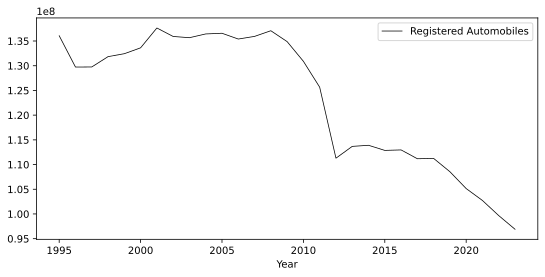

In [12]:
reg_cars.plot(y='Registered Automobiles', figsize=(9, 4), color='k', linewidth=0.75);

Vehicle sales data (for macroeconomic covariate):

- [Light vehicle and total vehicle sales - Bureau of Economic Analysis/Wards Intelligence](https://www.bea.gov/data/consumer-spending/main)
- [Retail New Passenger Car Sales](https://www.bts.gov/content/retaila-new-passenger-car-sales-thousands-units)
- [Monthly Transportation Statistics](https://data.bts.gov/Research-and-Statistics/Monthly-Transportation-Statistics/crem-w557/about_data)

Data description:
-  Autos--all passenger cars, including station wagons.
-  Light trucks--trucks up to 14,000 pounds gross vehicle weight, including minivans and
-  Sport utility vehicles.  Prior to the 2003 Benchmark Revision light trucks were up to 10,000 pounds.
-  Heavy trucks--trucks more than 14,000 pounds gross vehicle weight.
-  **Columns**:
    -  Autos  -- not seasonally adjusted (Thousands)	
    -  Light Trucks  -- not seasonally adjusted (Thousands) 	
    -  Light Total  --not seasonally adjusted (Thousands)	
    -  Total  -- not seasonally adjusted (Thousands)	
    -  Autos (SAAR) -- seasonally adjusted at annual rates (Millions)	
    -  Light Trucks (SAAR) -- seasonally adjusted at annual rates (Millions)	
    -  Light Total (SAAR) -- seasonally adjusted at annual rates (Millions)	
    -  Total (SAAR) -- seasonally adjusted at annual rates (Millions)

In [13]:
new_vehicle_sales = pd.read_csv(
    'data/us_new_passenger_car_sales.csv',
    index_col='Date',
    parse_dates=True,
    dayfirst=True)
new_vehicle_sales.tail()

,Month,Year,Autos,Light Trucks,Light Total,Total,Autos (SAAR),Light Trucks (SAAR),Light Total (SAAR),Total (SAAR)
Date,,,,,,,,,,
2024-11-01,November,2024,250.101,1123.392,1373.493,1411.970,3.074369,13.585438,16.659807,17.150438
2024-12-01,December,2024,245.098,1249.122,1494.220,1539.189,3.039268,13.829528,16.868796,17.322678
2025-01-01,January,2025,197.367,905.660,1103.027,1138.497,2.840438,12.651473,15.491911,15.983576
2025-02-01,February,2025,219.794,1000.994,1220.788,1252.337,2.951624,13.059812,16.011436,16.447194
2025-03-01,March,2025,287.595,1297.795,1585.390,1620.008,3.114295,14.652515,17.766811,18.170024


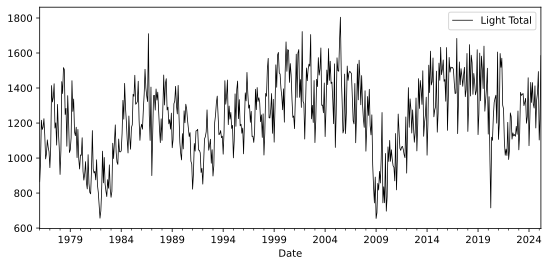

In [14]:
new_vehicle_sales.plot(y='Light Total', figsize=(9, 4), color='k', linewidth=0.75);

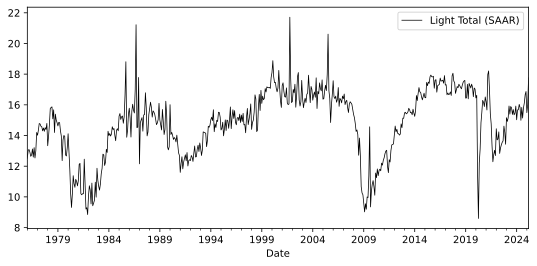

In [15]:
new_vehicle_sales.plot(y='Light Total (SAAR)', figsize=(9, 4), color='k', linewidth=0.75);